<a href="https://colab.research.google.com/github/thamizhannal/EIP3/blob/master/EIP3_Assign4_resnet34_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


## Resnet34 architecture

#### 1. Resnet34 architecture with custom changes a)7x7 kernel replaced with 3 conv layers of 3x3 kernel b) Dense&flatten replaced with 2 conv layers + BN+ Relu + GAP+softmax activation
#### 2) Image aug with 6 parameters
#### 3)  Used CLR
#### 4)  22.5M parameters
#### 5) input image size 64x64x3 output image size= 64x64x3, batch size=128
#### 6) Validation accuracy: 52.68%

In [0]:
!ls /content/gdrive/'My Drive'/EIP3



In [0]:
## 1. Download data from http://cs231n.stanford.edu/tiny-imagenet-200.zip
## 2. unzip it once
## 3. List the dir on which it is unzipped
## 4. Need not download, unzip data once again.
## 
!ls /content/gdrive/'My Drive'/EIP3 #tiny-imagenet-200/tiny-imagenet-200
!wget -P /content/gdrive/'My Drive'/EIP3 http://cs231n.stanford.edu/tiny-imagenet-200.zip

--2019-03-29 13:34:37--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘/content/gdrive/My Drive/EIP3/tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  37.8MB/s    in 9.0s    

2019-03-29 13:34:46 (26.2 MB/s) - ‘/content/gdrive/My Drive/EIP3/tiny-imagenet-200.zip’ saved [248100043/248100043]



In [0]:
!ls /content/gdrive/'My Drive'/EIP3/tiny-imagenet-200.zip


'/content/gdrive/My Drive/EIP3/tiny-imagenet-200.zip'


In [0]:
!rm -rf /content/gdrive/'My Drive'/EIP3/tiny-imagenet-200


In [0]:
!unzip -qq /content/gdrive/'My Drive'/EIP3/tiny-imagenet-200.zip -d /content/gdrive/'My Drive'/EIP3/


In [0]:
!ls /content/gdrive/'My Drive'/EIP3/tiny-imagenet-200

test  train  val  wnids.txt  words.txt


In [0]:
# Define Imports

import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib  inline
from keras.preprocessing.image import ImageDataGenerator
from sklearn import preprocessing

Using TensorFlow backend.


In [0]:
# Loading validation annotation & extract class labels
val_data = pd.read_csv(r"/content/gdrive/My Drive/EIP3/tiny-imagenet-200//val/val_annotations.txt", sep='\t', header=None, names=['File', 'Class', 'X', 'Y', 'H', 'W'])
val_data.drop(['X', 'Y', 'H', 'W'], axis=1, inplace=True)
val_data.head(3)

,File,Class
0,val_0.JPEG,n03444034
1,val_1.JPEG,n04067472
2,val_2.JPEG,n04070727


In [0]:
# Loading images as batches using ImageDataGenerator

# Use Augmentaion parameters as required.
train_datagen = ImageDataGenerator(
    rescale= 1./255,
    zoom_range = 0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rotation_range=10,
    horizontal_flip=True
    )

valid_datagen = ImageDataGenerator(rescale=1./255)


In [0]:
train_generator = train_datagen.flow_from_directory( r"/content/gdrive/My Drive/EIP3/tiny-imagenet-200/train/",
                                                    target_size=(64, 64), color_mode='rgb', 
                                                    batch_size=128, class_mode='categorical', shuffle=True, seed=42)


Found 100000 images belonging to 200 classes.


In [0]:
validation_generator = valid_datagen.flow_from_dataframe(val_data, directory='/content/gdrive/My Drive/EIP3/tiny-imagenet-200/val/images/',
                                                         x_col='File', y_col='Class', target_size=(64, 64),
                                                    color_mode='rgb', class_mode='categorical', batch_size=128, shuffle=True, seed=42)

Found 10000 images belonging to 200 classes.


In [0]:

X_train, Y_train = next(train_generator)
X_train.shape



(128, 64, 64, 3)

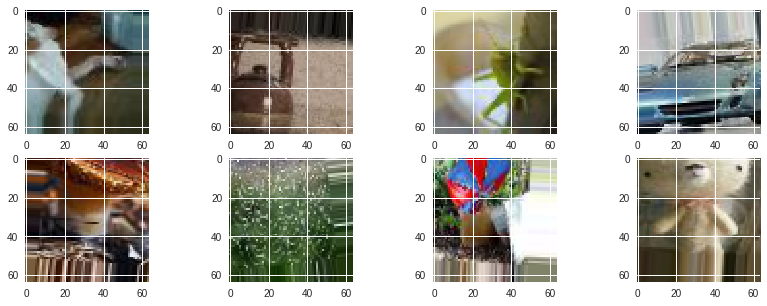

In [0]:
# Plot Generator images.

fig = plt.figure(figsize=(14, 5))

for i in range(8):
    sub = fig.add_subplot(2, 4, i + 1)
    sub.imshow(X_train[i,:,:], interpolation='nearest')


In [0]:
    
X_test, Y_test = next(validation_generator)
X_test.shape


(128, 64, 64, 3)

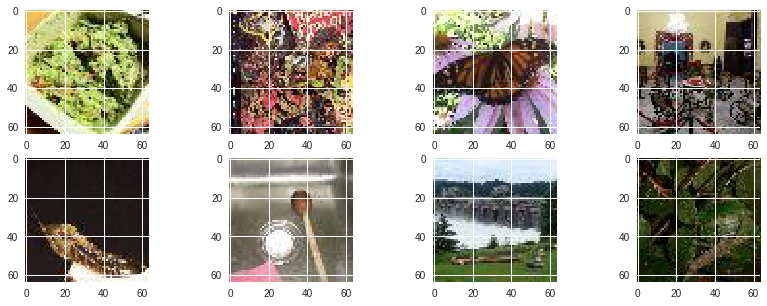

In [0]:
# Plot Generator images.

fig = plt.figure(figsize=(14, 5))

for i in range(8):
    sub = fig.add_subplot(2, 4, i + 1)
    sub.imshow(X_test[i,:,:], interpolation='nearest')

In [0]:
# Disclaimer: Below is base ResNet code was donwloaded from https://github.com/raghakot/keras-resnet
# 
# 
from __future__ import division

import six
from keras.models import Model
from keras.layers import (
    Input,
    Activation,
    Dense,
    Flatten
)
from keras.layers.convolutional import (
    Conv2D,
    MaxPooling2D,
    AveragePooling2D
)
from keras.layers.merge import add
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras import backend as K
from keras.layers import SeparableConv2D
from keras.layers import GlobalAveragePooling2D

def _bn_relu(input):
    """Helper to build a BN -> relu block
    """
    norm = BatchNormalization(axis=CHANNEL_AXIS)(input)
    return Activation("relu")(norm)


def _conv_bn_relu(**conv_params):
    """Helper to build a conv -> BN -> relu block
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(input):
        conv = Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(input)
        return _bn_relu(conv)

    return f


def _bn_relu_conv(**conv_params):
    """Helper to build a BN -> relu -> conv block.
    This is an improved scheme proposed in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(input):
        activation = _bn_relu(input)
        return Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(activation)

    return f


def _shortcut(input, residual):
    """Adds a shortcut between input and residual block and merges them with "sum"
    """
    # Expand channels of shortcut to match residual.
    # Stride appropriately to match residual (width, height)
    # Should be int if network architecture is correctly configured.
    input_shape = K.int_shape(input)
    residual_shape = K.int_shape(residual)
    stride_width = int(round(input_shape[ROW_AXIS] / residual_shape[ROW_AXIS]))
    stride_height = int(round(input_shape[COL_AXIS] / residual_shape[COL_AXIS]))
    equal_channels = input_shape[CHANNEL_AXIS] == residual_shape[CHANNEL_AXIS]

    shortcut = input
    # 1 X 1 conv if shape is different. Else identity.
    if stride_width > 1 or stride_height > 1 or not equal_channels:
        shortcut = Conv2D(filters=residual_shape[CHANNEL_AXIS],
                          kernel_size=(1, 1),
                          strides=(stride_width, stride_height),
                          padding="valid",
                          kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.0001))(input)

    return add([shortcut, residual])


def _residual_block(block_function, filters, repetitions, is_first_layer=False):
    """Builds a residual block with repeating bottleneck blocks.
    """
    def f(input):
        for i in range(repetitions):
            init_strides = (1, 1)
            if i == 0 and not is_first_layer:
                init_strides = (2, 2)
            input = block_function(filters=filters, init_strides=init_strides,
                                   is_first_block_of_first_layer=(is_first_layer and i == 0))(input)
        return input

    return f


def basic_block(filters, init_strides=(1, 1), is_first_block_of_first_layer=False):
    """Basic 3 X 3 convolution blocks for use on resnets with layers <= 34.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    def f(input):

        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv1 = Conv2D(filters=filters, kernel_size=(3, 3),
                           strides=init_strides,
                           padding="same",
                           kernel_initializer="he_normal",
                           kernel_regularizer=l2(1e-4))(input)
        else:
            conv1 = _bn_relu_conv(filters=filters, kernel_size=(3, 3),
                                  strides=init_strides)(input)

        residual = _bn_relu_conv(filters=filters, kernel_size=(3, 3))(conv1)
        return _shortcut(input, residual)

    return f


def bottleneck(filters, init_strides=(1, 1), is_first_block_of_first_layer=False):
    """Bottleneck architecture for > 34 layer resnet.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf

    Returns:
        A final conv layer of filters * 4
    """
    def f(input):

        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv_1_1 = Conv2D(filters=filters, kernel_size=(1, 1),
                              strides=init_strides,
                              padding="same",
                              kernel_initializer="he_normal",
                              kernel_regularizer=l2(1e-4))(input)
        else:
            conv_1_1 = _bn_relu_conv(filters=filters, kernel_size=(1, 1),
                                     strides=init_strides)(input)

        conv_3_3 = _bn_relu_conv(filters=filters, kernel_size=(3, 3))(conv_1_1)
        residual = _bn_relu_conv(filters=filters * 4, kernel_size=(1, 1))(conv_3_3)
        return _shortcut(input, residual)

    return f


def _handle_dim_ordering():
    global ROW_AXIS
    global COL_AXIS
    global CHANNEL_AXIS
    if K.image_dim_ordering() == 'tf':
        ROW_AXIS = 1
        COL_AXIS = 2
        CHANNEL_AXIS = 3
    else:
        CHANNEL_AXIS = 1
        ROW_AXIS = 2
        COL_AXIS = 3


def _get_block(identifier):
    if isinstance(identifier, six.string_types):
        res = globals().get(identifier)
        if not res:
            raise ValueError('Invalid {}'.format(identifier))
        return res
    return identifier


class ResnetBuilder(object):
    @staticmethod
    def build(input_shape, num_outputs, block_fn, repetitions):
        """Builds a custom ResNet like architecture.

        Args:
            input_shape: The input shape in the form (nb_channels, nb_rows, nb_cols)
            num_outputs: The number of outputs at final softmax layer
            block_fn: The block function to use. This is either `basic_block` or `bottleneck`.
                The original paper used basic_block for layers < 50
            repetitions: Number of repetitions of various block units.
                At each block unit, the number of filters are doubled and the input size is halved

        Returns:
            The keras `Model`.
        """
        _handle_dim_ordering()
        if len(input_shape) != 3:
            raise Exception("Input shape should be a tuple (nb_channels, nb_rows, nb_cols)")

        # Permute dimension order if necessary
        if K.image_dim_ordering() == 'tf':
            input_shape = (input_shape[1], input_shape[2], input_shape[0])

        # Load function from str if needed.
        block_fn = _get_block(block_fn)

        input = Input(shape=input_shape)
        #conv1 = _conv_bn_relu(filters=64, kernel_size=(7, 7), strides=(2, 2))(input)
        conv1 = _conv_bn_relu(filters=64, kernel_size=(3, 3), strides=(1, 1))(input)
        conv1 = _conv_bn_relu(filters=128, kernel_size=(3, 3), strides=(1, 1))(conv1)
        conv1 = _conv_bn_relu(filters=256, kernel_size=(3, 3), strides=(1, 1))(conv1)
        
        
              
        
        pool1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same")(conv1)

        block = pool1
        filters = 64
        for i, r in enumerate(repetitions):
            block = _residual_block(block_fn, filters=filters, repetitions=r, is_first_layer=(i == 0))(block)
            filters *= 2

        # Last activation
        block = _bn_relu(block)

        # Classifier block
        block_shape = K.int_shape(block)
        pool2 = AveragePooling2D(pool_size=(block_shape[ROW_AXIS], block_shape[COL_AXIS]),
                                 strides=(1, 1))(block)
        
        #X = GlobalAveragePooling2D(data_format='channels_last')(x)
        #X = ACtivation('softmax')(X)

        #flatten1 = Flatten()(pool2)
        #dense = Dense(units=num_outputs, kernel_initializer="he_normal",
                     #activation="softmax")(flatten1)
        
        conv_1_1 = Conv2D(filters=1024, kernel_size=(1,1),
                      strides=(1,1), padding="same",
                      kernel_initializer="he_normal",
                              kernel_regularizer=l2(1e-4))(pool2)
        conv_1_1 = _bn_relu(conv_1_1)
        '''
        conv_1_1 = Conv2D(filters=512, kernel_size=(1,1),
                      strides=(1,1), padding="same",
                      kernel_initializer="he_normal",
                              kernel_regularizer=l2(1e-4))(pool2)
        conv_1_1 = _bn_relu(conv_1_1)'''
        
                
        conv_1_1 = Conv2D(filters=200, kernel_size=(1,1),
                      strides=(1,1), padding="same",
                      kernel_initializer="he_normal",
                              kernel_regularizer=l2(1e-4))(conv_1_1)
        conv_1_1 = _bn_relu(conv_1_1)
        X = GlobalAveragePooling2D(data_format='channels_last')(conv_1_1)
        X = Activation('softmax')(X)
        #flatten1 = Flatten()(conv_1_1)

        model = Model(inputs=input, outputs=X)
        return model

    @staticmethod
    def build_resnet_18(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, basic_block, [2, 2, 2, 2])

    @staticmethod
    def build_resnet_34(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, basic_block, [3, 4, 6, 3])

    @staticmethod
    def build_resnet_50(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 4, 6, 3])

    @staticmethod
    def build_resnet_101(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 4, 23, 3])

    @staticmethod
    def build_resnet_152(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 8, 36, 3])

In [0]:
from keras.callbacks import *

class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

In [0]:
# You are using the triangular learning rate policy and
#  base_lr (initial learning rate which is the lower boundary in the cycle) is 0.1
#clr_triangular = CyclicLR(mode='triangular')
#model.compile(optimizer=Adam(0.1), loss='categorical_crossentropy', metrics=['accuracy'])
clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                        step_size=2000., mode='triangular2')

In [0]:
import os
checkpoint_path = "/content/gdrive/My Drive/EIP3/resnet34/cp-{epoch:04d}.hdf5"
model_save_path = "/content/gdrive/My Drive/EIP3/resnet34/resnet34.h5"
model_arch = "/content/gdrive/My Drive/EIP3/resnet34/resnet34_arch.png"
!mkdir -p /content/gdrive/'My Drive'/EIP3/resnet34/
!ls /content/gdrive/'My Drive'/EIP3/resnet34/

model_weights_path =  "/content/gdrive/My Drive/EIP3/resnet34/resnet18_weights.h5"
model_arch_path =  "/content/gdrive/My Drive/EIP3/resnet34/resnet18_model.json"


# Create checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                 save_weights_only=True,
                                                 verbose=1, 
                                                 period=5)

In [0]:
epochs=500
img_channels=3
img_rows=64
img_cols=64
nb_classes = 200
batch_size = 128
model = ResnetBuilder.build_resnet_34((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_42 (Conv2D)              (None, 64, 64, 64)   1792        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_38 (BatchNo (None, 64, 64, 64)   256         conv2d_42[0][0]                  
__________________________________________________________________________________________________
activation_38 (Activation)      (None, 64, 64, 64)   0           batch_normalization_38[0][0]     
__________________________________________________________________________________________________
conv2d_43 

In [0]:
# Save Model weight and Architecture in a separate files
# serialize model to JSON
model_json = model.to_json()
with open(model_arch_path, "w") as json_file:
    json_file.write(model_json)
print("Saved model to disk")  

# fit model

model.fit_generator(train_generator, epochs=epochs, steps_per_epoch=batch_size,
                    validation_steps=batch_size, validation_data=validation_generator,
                    callbacks=[cp_callback,clr])

  
# serialize weights to HDF5
model.save_weights(model_weights_path)
print("Saved model to disk")


Saved model to disk
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
128/128 [==============================] - 216s 2s/step - loss: 6.8263 - acc: 0.0360 - val_loss: 6.7012 - val_acc: 0.0215
Epoch 2/500
128/128 [==============================] - 193s 2s/step - loss: 5.8030 - acc: 0.0646 - val_loss: 6.0661 - val_acc: 0.0313
Epoch 3/500
128/128 [==============================] - 194s 2s/step - loss: 5.2549 - acc: 0.0860 - val_loss: 6.7430 - val_acc: 0.0198
Epoch 4/500
128/128 [==============================] - 195s 2s/step - loss: 4.9542 - acc: 0.1027 - val_loss: 6.0699 - val_acc: 0.0354
Epoch 5/500
128/128 [==============================] - 195s 2s/step - loss: 4.7886 - acc: 0.1140 - val_loss: 5.7866 - val_acc: 0.0370

Epoch 00005: saving model to /content/gdrive/My Drive/EIP3/resnet34/cp-0005.hdf5
Epoch 6/500
128/128 [==============================] - 194s 2s/step - loss: 4.6654 - acc: 0.1207 - val_loss: 6.6151 - val_acc: 0.0455
Epoch 7/500
128/128 [=========================

In [0]:
 # Loading previous weights and continue...
  !ls /content/gdrive/'My Drive'/EIP3/resnet34/

cp-0005.hdf5  cp-0045.hdf5  cp-0085.hdf5  cp-0125.hdf5	cp-0165.hdf5
cp-0010.hdf5  cp-0050.hdf5  cp-0090.hdf5  cp-0130.hdf5	cp-0170.hdf5
cp-0015.hdf5  cp-0055.hdf5  cp-0095.hdf5  cp-0135.hdf5	cp-0175.hdf5
cp-0020.hdf5  cp-0060.hdf5  cp-0100.hdf5  cp-0140.hdf5	cp-0180.hdf5
cp-0025.hdf5  cp-0065.hdf5  cp-0105.hdf5  cp-0145.hdf5	cp-0185.hdf5
cp-0030.hdf5  cp-0070.hdf5  cp-0110.hdf5  cp-0150.hdf5	resnet18_model.json
cp-0035.hdf5  cp-0075.hdf5  cp-0115.hdf5  cp-0155.hdf5
cp-0040.hdf5  cp-0080.hdf5  cp-0120.hdf5  cp-0160.hdf5


In [0]:
# Define Imports

import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib  inline
from keras.preprocessing.image import ImageDataGenerator
from sklearn import preprocessing

Using TensorFlow backend.


In [0]:
# Loading validation annotation & extract class labels
val_data = pd.read_csv(r"/content/gdrive/My Drive/EIP3/tiny-imagenet-200//val/val_annotations.txt", sep='\t', header=None, names=['File', 'Class', 'X', 'Y', 'H', 'W'])
val_data.drop(['X', 'Y', 'H', 'W'], axis=1, inplace=True)
val_data.head(3)

,File,Class
0,val_0.JPEG,n03444034
1,val_1.JPEG,n04067472
2,val_2.JPEG,n04070727


In [0]:
# Loading images as batches using ImageDataGenerator

# Use Augmentaion parameters as required.
train_datagen = ImageDataGenerator(#rescale= 1./255)
    rescale= 1./255,
    zoom_range = 0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rotation_range=10,
    horizontal_flip=True
    )

valid_datagen = ImageDataGenerator(rescale=1./255)


In [0]:
train_generator = train_datagen.flow_from_directory( r"/content/gdrive/My Drive/EIP3/tiny-imagenet-200/train/",
                                                    target_size=(64, 64), color_mode='rgb', 
                                                    batch_size=128, class_mode='categorical', shuffle=True, seed=42)


Found 100000 images belonging to 200 classes.


In [0]:
validation_generator = valid_datagen.flow_from_dataframe(val_data, directory='/content/gdrive/My Drive/EIP3/tiny-imagenet-200/val/images/',
                                                         x_col='File', y_col='Class', target_size=(64, 64),
                                                    color_mode='rgb', class_mode='categorical', batch_size=128, shuffle=True, seed=42)

Found 9998 images belonging to 200 classes.


In [0]:
from keras.callbacks import *

class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

In [0]:
# You are using the triangular learning rate policy and
#  base_lr (initial learning rate which is the lower boundary in the cycle) is 0.1
#clr_triangular = CyclicLR(mode='triangular')
#model.compile(optimizer=Adam(0.1), loss='categorical_crossentropy', metrics=['accuracy'])
clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                        step_size=2000., mode='triangular2')

In [0]:
#

#import os
checkpoint_path = "/content/gdrive/My Drive/EIP3/resnet34/cp-{epoch:04d}.hdf5"
model_save_path = "/content/gdrive/My Drive/EIP3/resnet34/resnet34_2.h5"
model_arch = "/content/gdrive/My Drive/EIP3/resnet34/resnet34_2_arch.png"
#!mkdir -p /content/gdrive/'My Drive'/EIP3/resnet34/
!ls /content/gdrive/'My Drive'/EIP3/resnet34/

model_weights_path =  "/content/gdrive/My Drive/EIP3/resnet34/resnet34_weights.h5"
model_arch_path =  "/content/gdrive/My Drive/EIP3/resnet34/resnet34_2_model.json"


# Create checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                 save_weights_only=True,
                                                 verbose=1, 
                                                 period=5)

cp-0005.hdf5  cp-0045.hdf5  cp-0085.hdf5  cp-0125.hdf5	cp-0165.hdf5
cp-0010.hdf5  cp-0050.hdf5  cp-0090.hdf5  cp-0130.hdf5	cp-0170.hdf5
cp-0015.hdf5  cp-0055.hdf5  cp-0095.hdf5  cp-0135.hdf5	cp-0175.hdf5
cp-0020.hdf5  cp-0060.hdf5  cp-0100.hdf5  cp-0140.hdf5	cp-0180.hdf5
cp-0025.hdf5  cp-0065.hdf5  cp-0105.hdf5  cp-0145.hdf5	cp-0185.hdf5
cp-0030.hdf5  cp-0070.hdf5  cp-0110.hdf5  cp-0150.hdf5	resnet18_model.json
cp-0035.hdf5  cp-0075.hdf5  cp-0115.hdf5  cp-0155.hdf5
cp-0040.hdf5  cp-0080.hdf5  cp-0120.hdf5  cp-0160.hdf5


In [0]:
from keras.models import model_from_json
# model.load_weights
# load json and create model
# Iteration1 Model loading
iter1_model_arch = "/content/gdrive/My Drive/EIP3/resnet34/resnet18_model.json"
json_file = open(iter1_model_arch, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
print("Loaded model arch fron json")

# load weights into new model
# Since previous model does not complete, loading latest check point weight
chk_point_weight_path = "/content/gdrive/My Drive/EIP3/resnet34/cp-0180.hdf5"
loaded_model.load_weights(chk_point_weight_path)
print("Loaded model from disk")





Instructions for updating:
Colocations handled automatically by placer.
Loaded model arch fron json
Loaded model from disk


In [0]:
# Compile loaded model
loaded_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
#model.summary()

In [0]:
epochs=500
img_channels=3
img_rows=64
img_cols=64
nb_classes = 200
batch_size = 128

# Save Model weight and Architecture in a separate files
# serialize model to JSON
model_json = loaded_model.to_json()
with open(model_arch_path, "w") as json_file:
    json_file.write(model_json)
print("Saved model to disk")  

# fit model

loaded_model.fit_generator(train_generator, epochs=epochs, initial_epoch=180, steps_per_epoch=batch_size,
                    validation_steps=batch_size, validation_data=validation_generator,
                    callbacks=[cp_callback,clr])

  
# serialize weights to HDF5
loaded_model.save_weights(model_weights_path)
print("Saved model to disk")


Saved model to disk
Epoch 181/500
128/128 [==============================] - 5649s 44s/step - loss: 2.4339 - acc: 0.4932 - val_loss: 4.6692 - val_acc: 0.2424
Epoch 182/500
128/128 [==============================] - 3428s 27s/step - loss: 2.5259 - acc: 0.4813 - val_loss: 4.3218 - val_acc: 0.2657
Epoch 183/500
128/128 [==============================] - 3943s 31s/step - loss: 2.6384 - acc: 0.4525 - val_loss: 4.4193 - val_acc: 0.2581
Epoch 184/500
128/128 [==============================] - 3806s 30s/step - loss: 2.7376 - acc: 0.4382 - val_loss: 4.9962 - val_acc: 0.2114
Epoch 185/500
128/128 [==============================] - 3823s 30s/step - loss: 2.9041 - acc: 0.4082 - val_loss: 5.2418 - val_acc: 0.2023

Epoch 00185: saving model to /content/gdrive/My Drive/EIP3/resnet34/cp-0185.hdf5
Epoch 186/500
128/128 [==============================] - 3739s 29s/step - loss: 2.9814 - acc: 0.3982 - val_loss: 5.8731 - val_acc: 0.1481
Epoch 187/500
128/128 [==============================] - 475s 4s/step 

In [0]:
# Loading previous iteration weight

# mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
 # Loading previous weights and continue...
  !ls /content/gdrive/'My Drive'/EIP3/resnet34/

cp-0005.hdf5  cp-0065.hdf5  cp-0125.hdf5  cp-0185.hdf5	cp-0245.hdf5
cp-0010.hdf5  cp-0070.hdf5  cp-0130.hdf5  cp-0190.hdf5	cp-0250.hdf5
cp-0015.hdf5  cp-0075.hdf5  cp-0135.hdf5  cp-0195.hdf5	cp-0255.hdf5
cp-0020.hdf5  cp-0080.hdf5  cp-0140.hdf5  cp-0200.hdf5	cp-0260.hdf5
cp-0025.hdf5  cp-0085.hdf5  cp-0145.hdf5  cp-0205.hdf5	cp-0265.hdf5
cp-0030.hdf5  cp-0090.hdf5  cp-0150.hdf5  cp-0210.hdf5	cp-0270.hdf5
cp-0035.hdf5  cp-0095.hdf5  cp-0155.hdf5  cp-0215.hdf5	resnet18_model.json
cp-0040.hdf5  cp-0100.hdf5  cp-0160.hdf5  cp-0220.hdf5	resnet34_2_model.json
cp-0045.hdf5  cp-0105.hdf5  cp-0165.hdf5  cp-0225.hdf5
cp-0050.hdf5  cp-0110.hdf5  cp-0170.hdf5  cp-0230.hdf5
cp-0055.hdf5  cp-0115.hdf5  cp-0175.hdf5  cp-0235.hdf5
cp-0060.hdf5  cp-0120.hdf5  cp-0180.hdf5  cp-0240.hdf5


In [0]:
# Loading Model from previous iteration

# Define Imports

import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib  inline
from keras.preprocessing.image import ImageDataGenerator
from sklearn import preprocessing

Using TensorFlow backend.


In [0]:
# Loading validation annotation & extract class labels
val_data = pd.read_csv(r"/content/gdrive/My Drive/EIP3/tiny-imagenet-200//val/val_annotations.txt", sep='\t', header=None, names=['File', 'Class', 'X', 'Y', 'H', 'W'])
val_data.drop(['X', 'Y', 'H', 'W'], axis=1, inplace=True)
val_data.head(3)

,File,Class
0,val_0.JPEG,n03444034
1,val_1.JPEG,n04067472
2,val_2.JPEG,n04070727


In [0]:
# Loading images as batches using ImageDataGenerator
# Use Augmentaion parameters as required.
train_datagen = ImageDataGenerator(
    rescale= 1./255,
    zoom_range = 0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rotation_range=10,
    horizontal_flip=True
    )

valid_datagen = ImageDataGenerator(rescale=1./255)


In [0]:
train_generator = train_datagen.flow_from_directory( r"/content/gdrive/My Drive/EIP3/tiny-imagenet-200/train/",
                                                    target_size=(64, 64), color_mode='rgb', 
                                                    batch_size=128, class_mode='categorical', shuffle=True, seed=42)


Found 100000 images belonging to 200 classes.


In [0]:
validation_generator = valid_datagen.flow_from_dataframe(val_data, directory='/content/gdrive/My Drive/EIP3/tiny-imagenet-200/val/images/',
                                                         x_col='File', y_col='Class', target_size=(64, 64),
                                                    color_mode='rgb', class_mode='categorical', batch_size=128, shuffle=True, seed=42)

Found 9998 images belonging to 200 classes.


In [0]:
from keras.callbacks import *

class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

In [0]:
# You are using the triangular learning rate policy and
#  base_lr (initial learning rate which is the lower boundary in the cycle) is 0.1
#clr_triangular = CyclicLR(mode='triangular')
#model.compile(optimizer=Adam(0.1), loss='categorical_crossentropy', metrics=['accuracy'])
clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                        step_size=2000., mode='triangular2')

In [0]:
#import os
checkpoint_path = "/content/gdrive/My Drive/EIP3/resnet34/cp-{epoch:04d}.hdf5"
model_save_path = "/content/gdrive/My Drive/EIP3/resnet34/resnet34_3.h5"
model_arch = "/content/gdrive/My Drive/EIP3/resnet34/resnet34_3_arch.png"
#!mkdir -p /content/gdrive/'My Drive'/EIP3/resnet34/
!ls /content/gdrive/'My Drive'/EIP3/resnet34/

model_weights_path =  "/content/gdrive/My Drive/EIP3/resnet34/resnet34_weights.h5"
model_arch_path =  "/content/gdrive/My Drive/EIP3/resnet34/resnet34_3_model.json"


# Create checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                 save_weights_only=True,
                                                 verbose=1, 
                                                 period=3)

cp-0005.hdf5  cp-0065.hdf5  cp-0125.hdf5  cp-0185.hdf5	cp-0245.hdf5
cp-0010.hdf5  cp-0070.hdf5  cp-0130.hdf5  cp-0190.hdf5	cp-0250.hdf5
cp-0015.hdf5  cp-0075.hdf5  cp-0135.hdf5  cp-0195.hdf5	cp-0255.hdf5
cp-0020.hdf5  cp-0080.hdf5  cp-0140.hdf5  cp-0200.hdf5	cp-0260.hdf5
cp-0025.hdf5  cp-0085.hdf5  cp-0145.hdf5  cp-0205.hdf5	cp-0265.hdf5
cp-0030.hdf5  cp-0090.hdf5  cp-0150.hdf5  cp-0210.hdf5	cp-0270.hdf5
cp-0035.hdf5  cp-0095.hdf5  cp-0155.hdf5  cp-0215.hdf5	resnet18_model.json
cp-0040.hdf5  cp-0100.hdf5  cp-0160.hdf5  cp-0220.hdf5	resnet34_2_model.json
cp-0045.hdf5  cp-0105.hdf5  cp-0165.hdf5  cp-0225.hdf5
cp-0050.hdf5  cp-0110.hdf5  cp-0170.hdf5  cp-0230.hdf5
cp-0055.hdf5  cp-0115.hdf5  cp-0175.hdf5  cp-0235.hdf5
cp-0060.hdf5  cp-0120.hdf5  cp-0180.hdf5  cp-0240.hdf5


In [0]:
from keras.models import model_from_json
# model.load_weights
# load json and create model
# Iteration1 Model loading
iter1_model_arch = "/content/gdrive/My Drive/EIP3/resnet34/resnet34_2_model.json"
json_file = open(iter1_model_arch, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
print("Loaded model arch fron json")

# load weights into new model
# Since previous model does not complete, loading latest check point weight
chk_point_weight_path = "/content/gdrive/My Drive/EIP3/resnet34/cp-0270.hdf5"
loaded_model.load_weights(chk_point_weight_path)
print("Loaded model from disk")


Instructions for updating:
Colocations handled automatically by placer.
Loaded model arch fron json
Loaded model from disk


In [0]:
# Compile loaded model
loaded_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
#model.summary()

In [0]:
epochs=500
img_channels=3
img_rows=64
img_cols=64
nb_classes = 200
batch_size = 128

# Save Model weight and Architecture in a separate files
# serialize model to JSON
model_json = loaded_model.to_json()
with open(model_arch_path, "w") as json_file:
    json_file.write(model_json)
print("Saved model to disk")  

# fit model

loaded_model.fit_generator(train_generator, epochs=epochs, initial_epoch=270, steps_per_epoch=batch_size,
                    validation_steps=batch_size, validation_data=validation_generator,
                    callbacks=[cp_callback,clr])

  
# serialize weights to HDF5
loaded_model.save_weights(model_weights_path)
print("Saved model to disk")


Saved model to disk
Epoch 271/500
128/128 [==============================] - 10551s 82s/step - loss: 2.4898 - acc: 0.5023 - val_loss: 4.1072 - val_acc: 0.3071
Epoch 272/500
128/128 [==============================] - 6319s 49s/step - loss: 2.5479 - acc: 0.4951 - val_loss: 4.1575 - val_acc: 0.2673
Epoch 273/500
128/128 [==============================] - 6729s 53s/step - loss: 2.6341 - acc: 0.4727 - val_loss: 4.2911 - val_acc: 0.2555

Epoch 00273: saving model to /content/gdrive/My Drive/EIP3/resnet34/cp-0273.hdf5
Epoch 274/500
128/128 [==============================] - 6557s 51s/step - loss: 2.7125 - acc: 0.4583 - val_loss: 4.7016 - val_acc: 0.2542
Epoch 275/500
128/128 [==============================] - 6924s 54s/step - loss: 2.8496 - acc: 0.4333 - val_loss: 5.3546 - val_acc: 0.2057
Epoch 276/500
102/128 [======================>.......] - ETA: 21:56 - loss: 2.9420 - acc: 0.4149

In [0]:
#

# Interation3 

In [0]:
# Loading previous iteration weight

# mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# Loading Model from previous iteration

# Define Imports

import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib  inline
from keras.preprocessing.image import ImageDataGenerator
from sklearn import preprocessing

In [0]:
# Loading validation annotation & extract class labels
val_data = pd.read_csv(r"/content/gdrive/My Drive/EIP3/tiny-imagenet-200//val/val_annotations.txt", sep='\t', header=None, names=['File', 'Class', 'X', 'Y', 'H', 'W'])
val_data.drop(['X', 'Y', 'H', 'W'], axis=1, inplace=True)
val_data.head(3)

,File,Class
0,val_0.JPEG,n03444034
1,val_1.JPEG,n04067472
2,val_2.JPEG,n04070727


In [0]:
# Loading images as batches using ImageDataGenerator
# Use Augmentaion parameters as required.
train_datagen = ImageDataGenerator( rescale= 1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)


In [0]:
train_generator = train_datagen.flow_from_directory( r"/content/gdrive/My Drive/EIP3/tiny-imagenet-200/train/",
                                                    target_size=(64, 64), color_mode='rgb', 
                                                    batch_size=128, class_mode='categorical', shuffle=True, seed=42)


Found 100000 images belonging to 200 classes.


In [0]:
validation_generator = valid_datagen.flow_from_dataframe(val_data, directory='/content/gdrive/My Drive/EIP3/tiny-imagenet-200/val/images/',
                                                         x_col='File', y_col='Class', target_size=(64, 64),
                                                    color_mode='rgb', class_mode='categorical', batch_size=128, shuffle=True, seed=42)

Found 9998 images belonging to 200 classes.


In [0]:
# You are using the triangular learning rate policy and
#  base_lr (initial learning rate which is the lower boundary in the cycle) is 0.1
#clr_triangular = CyclicLR(mode='triangular')
#model.compile(optimizer=Adam(0.1), loss='categorical_crossentropy', metrics=['accuracy'])
clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                        step_size=2000., mode='triangular2')

In [0]:
import os
checkpoint_path = "/content/gdrive/My Drive/EIP3/resnet34/cp-{epoch:04d}.hdf5"
model_save_path = "/content/gdrive/My Drive/EIP3/resnet34/resnet34.h5"
#model_arch = "/content/gdrive/My Drive/EIP3/resnet34/resnet34_arch.png"
#!mkdir -p /content/gdrive/'My Drive'/EIP3/resnet34/
#!ls /content/gdrive/'My Drive'/EIP3/resnet34/

model_weights_path =  "/content/gdrive/My Drive/EIP3/resnet34/resnet18_weights.h5"
model_arch_path =  "/content/gdrive/My Drive/EIP3/resnet34/resnet18_model.json"


# Create checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                 save_weights_only=True,
                                                 verbose=1, 
                                                 period=3)

In [0]:
!ls /content/gdrive/'My Drive'/EIP3/resnet34/resnet34_2_model.json

'/content/gdrive/My Drive/EIP3/resnet34/resnet34_2_model.json'


In [0]:

#

from keras.models import model_from_json
# model.load_weights
# load json and create model
# Iteration1 Model loading
iter1_model_arch = "/content/gdrive/My Drive/EIP3/resnet34/resnet34_2_model.json"
json_file = open(iter1_model_arch, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
print("Loaded model arch fron json")

# load weights into new model
# Since previous model does not complete, loading latest check point weight
chk_point_weight_path = "/content/gdrive/My Drive/EIP3/resnet34/cp-0273.hdf5"
loaded_model.load_weights(chk_point_weight_path)
print("Loaded model from disk")


Loaded model arch fron json
Loaded model from disk


In [0]:
from keras.optimizers import SGD

epochs=500
img_channels=3
img_rows=64
img_cols=64
nb_classes = 200
batch_size = 128

#model = ResnetBuilder.build_resnet_34((img_channels, img_rows, img_cols), nb_classes)
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
loaded_model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])
#model.summary()
# Compile loaded model
#loaded_model.compile(loss='categorical_crossentropy',
#              optimizer='sgd',
#              metrics=['accuracy'])
#model.summary()

In [0]:
from keras.models import model_from_json


loaded_model.fit_generator(train_generator, epochs=epochs, steps_per_epoch=(train_generator.n//batch_size), initial_epoch=273,
                    validation_steps=(validation_generator.n//batch_size), validation_data=validation_generator,
                    callbacks=[cp_callback,clr])

   
# serialize weights to HDF5
model.save_weights(model_weights_path)
print("Saved model to disk")

Epoch 274/500
781/781 [==============================] - 29315s 38s/step - loss: 2.2344 - acc: 0.5625 - val_loss: 2.5485 - val_acc: 0.5124
Epoch 275/500
781/781 [==============================] - 809s 1s/step - loss: 2.1048 - acc: 0.5918 - val_loss: 2.5618 - val_acc: 0.5116
Epoch 276/500
781/781 [==============================] - 808s 1s/step - loss: 2.0193 - acc: 0.6107 - val_loss: 2.5068 - val_acc: 0.5206

Epoch 00276: saving model to /content/gdrive/My Drive/EIP3/resnet34/cp-0276.hdf5
Epoch 277/500
781/781 [==============================] - 808s 1s/step - loss: 1.9381 - acc: 0.6278 - val_loss: 2.5150 - val_acc: 0.5238
Epoch 278/500
781/781 [==============================] - 808s 1s/step - loss: 1.8732 - acc: 0.6430 - val_loss: 2.4451 - val_acc: 0.5356
Epoch 279/500
781/781 [==============================] - 809s 1s/step - loss: 1.8347 - acc: 0.6530 - val_loss: 2.5075 - val_acc: 0.5268

Epoch 00279: saving model to /content/gdrive/My Drive/EIP3/resnet34/cp-0279.hdf5
Epoch 280/500
641

#### Conclusion:
#### Resnet34 architecture
#### 1. Resnet34 architecture with custom changes a)7x7 kernel replaced with 3 conv layers of 3x3 kernel b) Dense&flatten replaced with 2 conv layers + BN+ Relu + GAP+softmax activation
#### 2) Image aug with 6 parameters
#### 3) Used CLR
#### 4) 22.5M parameters
#### 5) input image size 64x64x3 output image size= 64x64x3, batch size=128
#### 6) highest Validation accuracy: 52.68%
#### 7) Since colab got timed out, complete model training took 3 iterations with 279 epochs.
#### 8) used 'adam' optimizer with clr for first 2 iterations and used 'sgd' for 3rd iteration.